In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('x_imputed_less_response.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

/var/folders/26/l89mqgp17zj82yvlmd3z3r200000ks/T/ipykernel_39537/1403159800.py:12: DtypeWarning: Columns (221,222,229,230,231,232,239,240,252,258,259,260,262,264,268,269,270,281,282,288,289,290,291,292,293,294,297,298,299,300,315,316,317,318,319,322,323,324,332,333,334,335,336,337,338,340,341,362,363,364,365,366,367,368,369,370,371,372,373,374,375,377,378,379,380,381,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,408,409,410,411,422,423,424,425,426,427,428,429,430,431,432,433,435,438,439,440,441,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,482,483,484,485,486,487,488,489,490,491,492,493) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('x_imputed_less_response.csv')


In [2]:
y_train = y_train.fillna(y_train.mean())

In [3]:
X

,statecounty_y,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2016,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2017,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2018,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2019,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2020,highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2021,percent_of_days_with_level_of_pm2.5_exceeding_the_standard_epa2016,percent_of_days_with_level_of_pm2.5_exceeding_the_standard_epa2017,percent_of_days_with_level_of_pm2.5_exceeding_the_standard_epa2018,...,"asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2019_2019","asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2020_2020","asian_ischemic_heart_disease_death_rate_per_100,000_cdc_ehtracking_2021_2021","api_single_race_stroke_death_rate_per_100,000_cdc_ehtracking_2018_2018","api_stroke_death_rate_per_100,000_cdc_ehtracking_2018_2018",percent_of_farmers_market_accept_snap_usda_2018_2018,airpollutant:_acetaldehyde_ug_m^3_epa2017_2018,airpollutant:_benzene_ug_m^3_epa2017_2018,airpollutant:_carbon_tetrachloride_ug_m^3_epa2017_2018,airpollutant:_formaldehyde_ug_m^3_epa2017_2018
0,01Autauga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,0.0,1.455,0.185,0.440,1.765
1,01Baldwin,7.2,7.4,7.1,7.5,7.9,7.3,0.0%,0.0%,0.0%,...,NaN,NaN,162.9,80.1,80.1,0.0,1.125,0.165,0.440,1.435
2,01Barbour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,50.0,1.450,0.175,0.435,1.735
3,01Bibb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,128.5,128.5,0.0,1.575,0.180,0.440,1.880
4,01Blount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.215,0.195,0.435,1.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,66Guam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3288,69Commonwealth of the Northern Mariana Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3289,72Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3290,74U.S. Minor Outlying Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2016    0
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2017    0
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2018    0
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2019    0
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2020    0
                                                                      ..
percent_of_farmers_market_accept_snap_usda_2018_2018                   0
airpollutant:_acetaldehyde_ug_m^3_epa2017_2018                         0
airpollutant:_benzene_ug_m^3_epa2017_2018                              0
airpollutant:_carbon_tetrachloride_ug_m^3_epa2017_2018                 0
airpollutant:_formaldehyde_ug_m^3_epa2017_2018                         0
Length: 1816, dtype: int64
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2016    0
highest_pm2.5_concentration_microgram_m^3_of_annual_average_epa2017    0
highest_pm2.5_concentrat

In [12]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


Reloading Tuner from my_dir/multi_target_hyperparam_tuning/tuner0.json


In [13]:
# tuner.results_summary()


In [14]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 657.0701 - mae: nan      


Best Model Test Loss: 748.9151000976562, Test MAE: nan


In [15]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [17]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values  # Convert X_train to NumPy array
X_test_np = X_test.values    # Convert X_test to NumPy array

# Initialize GradientExplainer
explainer = shap.GradientExplainer(best_model, X_train_np)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_np)


/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(659, 1816))']
  warnings.warn(msg)
/home/tonyluo/.local/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 1816))']
  warnings.warn(msg)


In [18]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(659, 1816, 1)


In [19]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                                feature  importance
1750  api_percentage_fee_for_service_ffs_medicare_en...    2.523729
1787  amount_of_snap_redemption_per_snap_authorized_...    2.159712
1788       amount_of_snap_benefits_per_capita_usda_2017    1.941938
1332   community_resilience_national_percentile_nri2020    1.891696
1740  percent_adults_20yrs_and_over_physical_inactiv...    1.862021
...                                                 ...         ...
262   api_single_race_male_obesity_and_hyperalimenta...    0.000000
256   api_single_race_male_renal_failure_deaths_rate...    0.000000
257   api_single_race_female_renal_failure_deaths_ra...    0.000000
1325  nhpi_multi_race_percent_population_under_18_un...    0.000000
1324  nhpi_multi_race_percent_population_under_pover...    0.000000

[1816 rows x 2 columns]


/home/tonyluo/.local/lib/python3.9/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


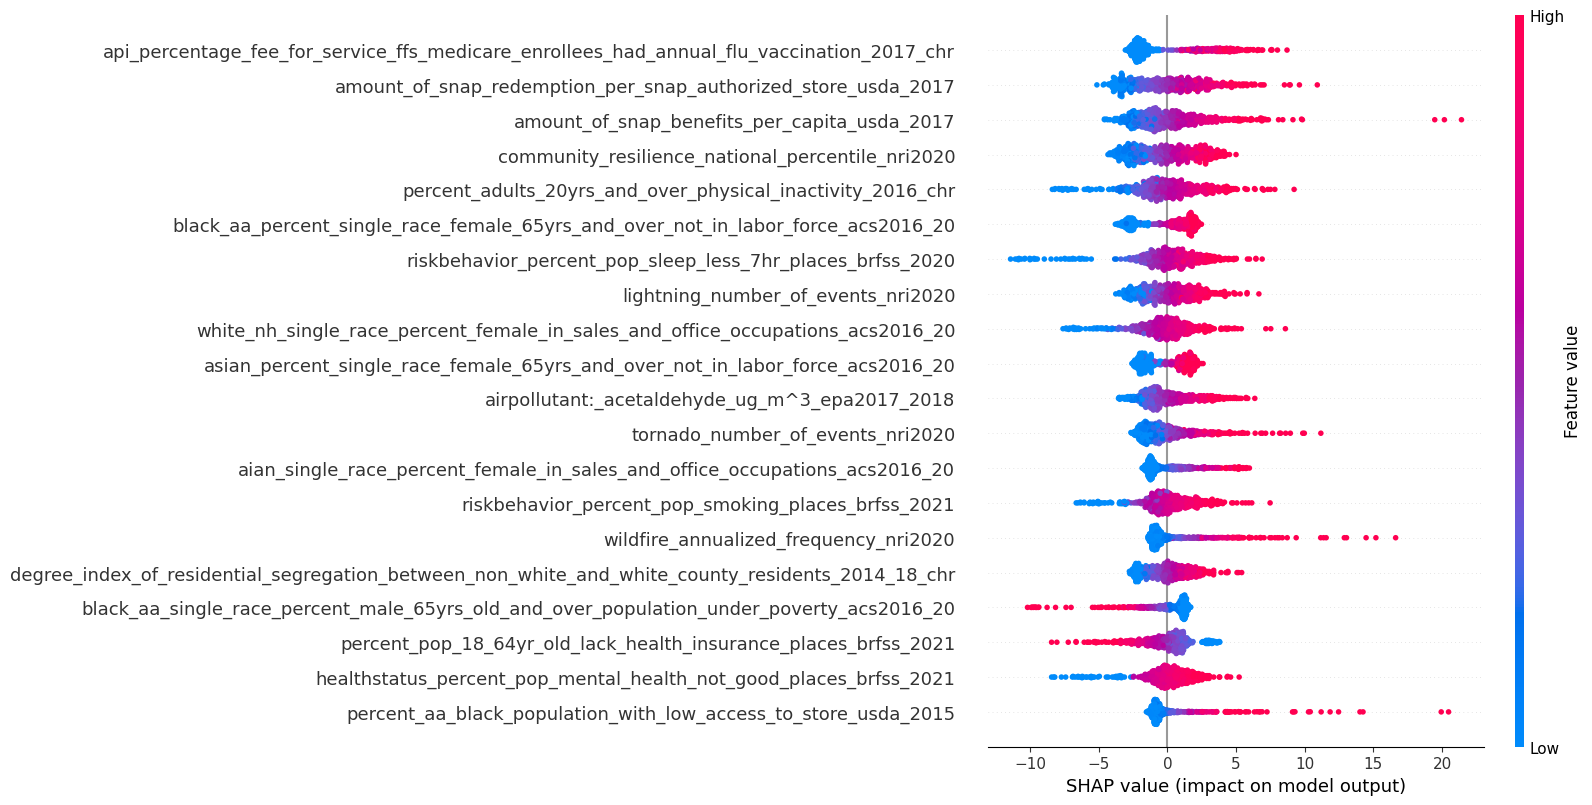

In [20]:
import shap
shap.summary_plot(shap_values, X_test, max_display=20)  # Adjust max_display as needed
